NAME : test.py
DATE STARTED : Feb 17, 2020
AUTHORS : AMB, Benjamin Vaughan, Victoria Butler
PURPOSE : This is a python version of Adi and Alfredo's IDL lensing software
ported from DF_LensCat_FP.pro
EXPLANATION :
CALLING SEQUENCE :
INPUTS :  input_cat: input catalogue to be lensed.
       FILE_DFX / FILE_DFY: deflection field in X & Y (provided by Adi Zitrin. Use READ_ZITRIN.pro read this files).
       Lens_z: cluster (lens) redshift.
       Pix_Scale: pixel size (Pix_Scale x Pix_Scale) in arcsec (default: 0.06" x 0.06").
       LL: size of square map (L x L) in arcmin.
       NPIXELS: number of pixels in map (NPIXELS).
       SEARCHLENSED: this number is to find the lensed source which can be extended (arcs). Use the default value 0.75
OUTPUTS : an array with source ID (input), X position (input), Y position (input), redshift (input),unlensed flux (input), lensed X position, lensed Y position, magnification]
**Note that, to build the lensed map, you have to you should use the lensed positions and unlensed flux*magnification**

REVISION HISTORY :

# Modules and Inits

In [2]:
from astropy.cosmology import LambdaCDM as LCDM
# from read_zitrin import *
import numpy as np
import sys
import matplotlib.pyplot as plt
from math import *
from astropy.wcs import WCS as world
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from scipy.ndimage.measurements import label
from astropy.convolution import Gaussian2DKernel
import time


#these are some important constants
hb  = 0.7                    #Hubble constant (Ho = 100*hb)
OMm = 0.3                    #Omega Matter (dark + baryonic)
OMl = 0.7                    #Omega Lambda
OMk = 1. - OMm - OMl         #Omega curvature
DH = 2997.92/hb              #Hubble Distance in Mpc => DH = (c * 1e-3)/Ho

# using Planck 2015 cosmology ... Ade+2015 a (Table 4 last column)
#     hb  = 0.6774                    ; Hubble constante (Ho = 100*hb)
#     OMm = 0.3089                    ; Omega Matter (dark + baryonic)
#     OMl = 0.6911                    ; Omega Lambda
#     OMk = 1.0 - OMm - OMl           ; Omega curvature
#     DH  = 2997.92/hb                  ; Hubble Distance in Mpc => DH = (c * 1e-3)/Ho

# Setting up Helper Functions

In [3]:
import numpy as np

def centroid(arr):
    s = arr.shape
    total = np.sum(arr)
    
    liny = np.arange(0, s[0])
    linx = np.arange(0, s[1])
    
    xweight, yweight = np.meshgrid(linx, liny)
    
    xcm =  np.sum(arr * xweight) / total
    ycm =  np.sum(arr * yweight) / total
    
    center = np.array([xcm, ycm], dtype=np.float32)
    return center

def find_regions(img, start_x, start_y, max_val, min_val):
    x_indexes, y_indexes = np.where(img)

    x_indexes[0] = start_x
    y_indexes[0] = start_y
    x_indexes[start_x] = 0
    y_indexes[start_y] = 0
    
    npixels = img.shape[0] * img.shape[1]
    
    if npixels <= 4:
        good_x, good_y = np.where(np.logical_and(img >= min_val, img <= max_val))
        

    else:
        count = 0
        good_x = [start_x]
        good_y = [start_y]
        good = [[start_x, start_y]]
        flag = True
        while count <= len(good_x) - 1:
            min_x = good_x[count] - 1
            if min_x < 0:
                min_x = 0
            max_x = good_x[count] + 2
            if max_x > img.shape[0]:
                max_x = good_x[count] + 1
                if max_x > img.shape[0]:
                    max_x = good_x[count]
            min_y = good_y[count] - 1 
            if min_y < 0:
                min_y = 0
            max_y = good_y[count] + 2
            if max_y > img.shape[1]:
                max_y = good_y[count] + 1
                if max_y > img.shape[1]:
                    max_y = good_y[count]
                    
            patch = img[min_x:max_x, min_y:max_y]
            true_x, true_y = np.where(np.logical_and(patch >= min_val, patch <= max_val))
            count += 1
            for indx, indy in zip(true_x, true_y):
                new_x_ind = indx + min_x
                new_y_ind = indy + min_y
                if [new_x_ind,new_y_ind] not in good:
                    good.append([new_x_ind, new_y_ind])
                    good_x.append(new_x_ind)
                    good_y.append(new_y_ind)

            if count > npixels:
                break
        
        first_val = img[good_x[0], good_y[0]]
        if not np.logical_and(first_val >= min_val, first_val <= max_val):
            good_x.remove(good_x[0])
            good_y.remove(good_y[0])
        
    return good_x, good_y
                                    
    
def ij(inds, n):
    j = int( inds / n)
    i = round(inds - j * n)
    return i, j

def deriv(y):
    n = len(y)
    d = np.subtract( np.roll(y, -1), np.roll(y, 1)) / 2.
    d[0] = (-3.0 *y[0] + 4.0 * y[1] - y[2]) / 2.
    d[n-1] = (3.0 * y[n-1] - 4.0*y[n-2] + y[n-3]) / 2.
    return d

def read_input(filename):
    arr  = np.loadtxt(filename, unpack=True)
    return arr

In [100]:
cat = np.load('SIDES_PMW_0.npy', allow_pickle=True)

# num, dfxx, dfyy, dfredz, dfflux = np.loadtxt('rxj_lense_test.txt', unpack=True)

pixsize = 0.25 #in arcseconds
map_size = [300,300]
c_z = 0.451
file_dfx = 'alpha_x_ALL_rxj1347_z1p75.txt'
file_dfy = 'alpha_y_ALL_rxj1347_z1p75.txt'
mag_file = 'magnification_ALL_rxj1347_z1p75.txt'
searchlensed= 0.75
SLregime= 2 # this is in arcmins
DefField_Norm=None
main_source_z= 1.75
LL = 16.6 # map size in arcmin (LxL)
lens_z = 0.451

In [56]:
# Define input cluster redshift, source redshift to which deflection field is scaled to, and the pixel
# scale (both are input provided by Adi Zitrin). Often the deflection field will be scaled to DLS/DS=1.

#if pixsize is not provided use 0.06 arcs/pix
try:
    pixsize = pixsize
except NameError:
    pixsize = 0.06 
    
#if searchlensed is not given use default value of 0.75
try:
    searchlensed = searchlensed
except NameErorr:
    searchlensed = 0.75
    
#use default value of 2 arcmin if SLregime not given
try:
    SLregime = SLregime
except NameErorr:
    SLregime = 2
    
#if SLregime is bigger than the mapsize make the SLregime the mapsize
if SLregime > LL:
    SLregime = LL

print('SLregime :',SLregime)       
SL_pix = SLregime * 60 / pixsize #converting strong lensing regime from arcmin to pixels
#for the weakly lensed region we don't estimate the whole image plane but limit to a WLmask x WLmask area around the lensed source
WLmask = 2.0 # reference scale to estimate WL region in arcmin
WLmask = WLmask / pixsize * 60.0 #WLmask now in pixels

print('WL region (in pixels):', WLmask)


#estimate the angular distance to the lensing cluster (z = c_z)
cos_model = LCDM(hb, OMm, OMl)
DL1 = cos_model.luminosity_distance(c_z).value / (1 + c_z)**2  # * 100 to match units in Adi's code.

print('DL1 (luminosity distance) :',DL1)

#If this is scaled to a certain source redshift (main_sourcez) then calculate angular diameter distances
if main_source_z != None:
    #estimate angular diameter distance to main_source_z
    DS1 = cos_model.luminosity_distance(main_source_z).value / (1 + main_source_z)**2
    #estimate distance between the lensing cluster and main_source_z
    DLS1 = (DS1*(1. + main_source_z) - DL1*(1 + lens_z)) / (1. + main_source_z) # WARNING: only true for Omega_k = 0

    #estimate the deflection field normalization
    DLS1_DS1 = DLS1 / DS1

elif DefField_Norm != None: # if main_source_z not provided but deflection field norm was given.
    DLS1_DS1 = DefField_Norm

else:
    DLS1_DS1 = 1. #if main_source_z was not provided the deflection field normalization should (very likely) be 1

#read in the deflection fields provided by Adi Zitrin, (npixel X npixel)
wl_alpha_x = np.loadtxt(file_dfx) #deflection field of x
wl_alpha_y = np.loadtxt(file_dfy) #deflection field of y

# make sure the deflection fields are NxN
if wl_alpha_x.shape[0] > wl_alpha_x.shape[1]:
    wl_alpha_x = wl_alpha_x[0:wl_alpha_x.shape[1], :]
    wl_alpha_y = wl_alpha_y[0:wl_alpha_X.shape[1], :]

elif wl_alpha_x.shape[1] < wl_alpha_x.shape[0]:
    wl_alpha_x = wl_alpha_x[:, 0:wl_alpha_x.shape[0]]
    wl_alpha_y = wl_alpha_y[:, 0:wl_alpha_x.shape[0]]

#weak lensing estimates
wl_lengthx = len(wl_alpha_x[:,0])
wl_lengthy = len(wl_alpha_y[0,:])
# Print check
print('This should be 1 ...', wl_lengthx/wl_lengthy)

wl_x = np.arange(start=1, stop=wl_lengthx + 1)
wl_y = np.arange(start=1, stop=wl_lengthy + 1)

WLY, WLX = np.meshgrid(wl_x, wl_y)

#weak lensing gradients
wl_dax_dy = np.zeros((wl_lengthx, wl_lengthy))
wl_dax_dx = np.zeros((wl_lengthx, wl_lengthy))
wl_day_dy = np.zeros((wl_lengthx, wl_lengthy))
wl_day_dx = np.zeros((wl_lengthx, wl_lengthy))


if wl_lengthx == wl_lengthy:
    for i in range(wl_lengthx):
        wl_dax_dy[i,:] = deriv(wl_alpha_x[i,:])
        wl_dax_dx[:,i] = deriv(wl_alpha_x[:,i])
        wl_day_dy[i,:] = deriv(wl_alpha_y[i,:])
        wl_day_dx[:,i] = deriv(wl_alpha_y[:,i])

else:
    for i in range(wl_lengthx):
        wl_dax_dx[:,i] = deriv(wl_alpha_x[:,i])
        wl_day_dx[:,i] = deriv(wl_alpha_y[:,i])

    for i in range(wl_lengthy):
        wl_dax_dy[i,:] = deriv(wl_alpha_x[i,:])
        wl_day_dy[i,:] = deriv(wl_alpha_y[i,:])


#Strong Lensing
#make a copy of the grids but only over the SL region

dim_minx = int((wl_lengthx-SL_pix)/2) 
dim_plusx = int((wl_lengthx+SL_pix)/2) + 1 #numpy end interval is exclusive. 
dim_miny = int((wl_lengthy-SL_pix)/2) 
dim_plusy = int((wl_lengthy+SL_pix)/2) + 1

sl_alpha_x = wl_alpha_x[dim_minx:dim_plusx,dim_minx:dim_plusx]
sl_alpha_y = wl_alpha_y[dim_miny:dim_plusy,dim_miny:dim_plusy]

sl_dax_dy = wl_dax_dy[dim_miny:dim_plusy,dim_miny:dim_plusy]
sl_dax_dx = wl_dax_dx[dim_minx:dim_plusx,dim_minx:dim_plusx]
sl_day_dy = wl_day_dy[dim_miny:dim_plusy,dim_miny:dim_plusy]
sl_day_dx = wl_day_dx[dim_minx:dim_plusx,dim_minx:dim_plusx]
sl_lengthx = len(sl_alpha_x[:,0])
sl_lengthy = len(sl_alpha_y[0,:])

sl_x = np.arange(start=1, stop=int(sl_lengthx+1)) 
sl_y = np.arange(start=1, stop=int(sl_lengthy+1))

SLY, SLX = np.meshgrid(sl_x, sl_y)
# shift between WL and SL frames (you will need this number to estimate the correct positions of the weak and strong lensed sources)
pos_shift = (wl_lengthx-sl_lengthx)/2.

print('pos shift between sl and wl [pixels]:',pos_shift)
    
#     return cos_model, SLX, SLY, pos_shift, DLS1_DS1, DL1, lens_z, sl_dax_dy, sl_dax_dx, sl_day_dy, sl_day_dx, sl_alpha_x, sl_alpha_y, sl_lengthx, sl_lengthy

SLregime : 2
WL region (in pixels): 480.0
DL1 (luminosity distance) : 118947.17451678515
This should be 1 ... 1.0
pos shift between sl and wl [pixels]: 1759.5


In [107]:
#------------------------------------------------------------- OJO -----------------------------------------------------------------

# Read source catalogue (input_cat)
print('Reading Catalogue to be lensed')
dfxx = cat.item().get('RA') * 3600 
dfyy = cat.item().get('DEC') * 3600
dfflux = cat.item().get('Flux') 
dfredz = cat.item().get('Redshift')

mask = dfredz > c_z

dfxx = dfxx[mask]
dfyy = dfyy[mask]
dfflux = dfflux[mask]
dfredz = dfredz[mask]

# Convert coordinates from degrees to pixels in the larger WL frame
map_x = map_size[0] / 2.
map_y = map_size[1] / 2.
xx = (dfxx  + LL * 30)/ pixsize
yy = (dfyy  + LL * 30)/ pixsize


print(dfxx)

# Number of sources in catalogue
nsources = len(xx)
print('nsources :',nsources)



Reading Catalogue to be lensed
[ 235.07027177  -17.11692823 -362.28132823 ...  389.15747177  -12.21372823
  -66.96972823]
nsources : 1571


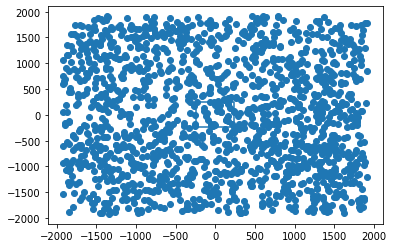

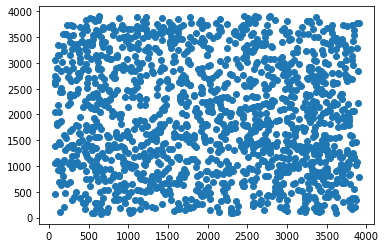

In [108]:
# plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

sly = SLregime * 30 / pixsize 
slx = SLregime * 30 / pixsize 
SL_x = [ slx, slx, -slx, -slx,  slx]
SL_y = [-sly, sly,  sly, -sly, -sly]

plt.plot(SL_x, SL_y)
plt.scatter(dfxx / pixsize, dfyy / pixsize)
plt.show()


plt.scatter(xx, yy)
plt.show()

In [109]:
 (min_y + multi_ll) < len(source_dist[0,:])
    
print(indX)
print(indY)
print(temp_multi_x, temp_multi_y)
print(min_y, multi_ll)

print(min_y + multi_ll)
print(len(source_dist[0,:]))




print(min_y + multi_ll < len(source_dist[0,:]))

[1680 1681]
[2782 2782]
2 1
406 2
408
721
True


In [110]:
print('Set Up Complete beggining to lense sources')

start = time.time()

for i in range(nsources):
#     print('lensing source %s' % str(i + 1))
    # begin dealing with foreground sources (we don't need to lens these) ---------------------
    if c_z > dfredz[i]:
#         print('source %s is a foreground source' % str(i + 1))
        mindX = xx[i]
        mindY = yy[i]
        mmu = 1.0
        
    else:
        # Finish dealing with foreground sources --------------------------------------------------
        # Begin dealing with background sources (we do need to lens these)
        # Estimate angular diameter distance to source (z = dfredz)
        DS2 = cos_model.luminosity_distance(dfredz[i]).value / (1.0+dfredz[i])**2  # * 100 to match units in Adi's code
        # Estimate distance between the lensing cluster and source
        DLS2 = (DS2*(1.+dfredz[i]) - DL1*(1.+lens_z)) / (1 + dfredz[i])
        #this is the factor to scale the deflection field to different source redshifts.
        scaling_factor = (DLS2/DS2) / DLS1_DS1

        #begin SL regime analysis
        x_check = abs(dfxx[i]) < SLregime * 30
        y_check = abs(dfyy[i]) < SLregime * 30
        xy_check = x_check and y_check
        if xy_check:
#             print('beggining strong lensing regime')
            #estimate source position in SL frame
            source_x = int((dfxx[i] + SLregime * 30) / pixsize)
            source_y = int((dfyy[i] + SLregime * 30) / pixsize)
            #estimate the magnifications (from lensing eq.), adding sl_day_dx and sl_day_dy element by element
            sl_dax_day_dxdy = np.multiply(sl_dax_dx, sl_day_dy)
            sl_day_dax_dydx = np.multiply(sl_dax_dy, sl_day_dx)

            poisson = np.add(sl_dax_dx, sl_day_dy) * scaling_factor
            magnification = abs(1 / (1 - poisson + (sl_dax_day_dxdy - sl_day_dax_dydx) * scaling_factor))
            #will need to double check that these matrix operations work on sl_day_dx and sl_dax_dx
            #find the pixels where lensed image (or images) end up
            x_side = SLX - sl_alpha_x * scaling_factor - source_x
            y_side = SLY - sl_alpha_y * scaling_factor - source_y
            source_dist = np.sqrt(x_side**2 + y_side**2)
            indX, indY = np.where(source_dist < searchlensed) #this may have to change for a 2D array
            #if a lensed source was found within searched lensed do this
        
            if len(indX) > 1:
                
                #cut a square sub-map including all pixels with "source_dist < searchlensed" for easy computation
                min_x = min(indX)
                min_y = min(indY) 
                max_x = max(indX)
                max_y = max(indY)
                temp_multi_x = max_x - min_x
                temp_multi_y = max_y - min_y

                
                #pick the larger of the two sides
                if temp_multi_x - temp_multi_y >= 0:
                    multi_ll = temp_multi_x
                else:
                    multi_ll = temp_multi_y
                
                #fix min_x / min_y so that we don't go over the edge of the greater map with the sub map.
                while min_x >= source_dist.shape[0] - 1:
                    min_x -= 1
                while min_y >= source_dist.shape[1] - 1:
                    min_y -= 1
                
                
                if (min_x + multi_ll) < len(source_dist[:,0]):
                    if (min_y + multi_ll) < len(source_dist[0,:]):
                        regmap = source_dist[min_x:min_x + multi_ll + 1, min_y:min_y+multi_ll + 1]
                    else:
                        regmap = source_dist[min_x:min_x + multi_ll+ 1, min_y-1:source_dist.shape[0]]
                elif (min_y + multi_ll) < len(source_dist[0,:]):
                    regmap = source_dist[min_x-1:source_dist.shape[0], min_y:min_y + multi_ll + 1]
                else:
                    regmap = source_dist[min_x-1:source_dist.shape[0], min_y-1:source_dist.shape[0]]

                    
                
                indX2, indY2 = np.where(regmap < searchlensed)
  

                reg_centroids = np.zeros( (2, len(indX)))
                for j in range(len(indX2)):
                    regmask = np.zeros( (len(regmap[:,0]), len(regmap[0,:])))
                    region = find_regions(regmap, indX2[j], indY2[j], searchlensed, 0)
                    regmask[region] = 1.0
                    reg_centroids[:,j] = centroid(regmap * regmask)
                    
            
                #remove duplicates.
                reg_centroidsx, indexes = np.unique(reg_centroids[0], return_index=True)
                reg_centroidsy = reg_centroids[1, indexes]
                
                
                n_centroids = 0
            
                mindX = np.zeros((len(reg_centroidsx)))
                mindY = np.zeros((len(reg_centroidsx)))
                mmu = np.zeros((len(reg_centroidsx)))
                        
                for j in range(len(reg_centroidsx)):
                    ic = np.where(np.logical_and(reg_centroids[0] == reg_centroidsx[j], reg_centroids[1] == reg_centroidsy[j]))[0]    

                    
                    if ic.size > 0 and n_centroids == 0:
                        n_centroids += 1
#                         print('found multiples')
                        
                        tempX = np.mean(indX2[ic] + min(indX))
                        tempY = np.mean(indY2[ic] + min(indY))
                        mmu[0] = np.mean(magnification[indX2[ic] + min(indX), indY2[ic] + min(indY)])

                        mindX[0] = tempX + pos_shift
                        mindY[0] = tempY + pos_shift
                        
                    elif ic.size > 0 and n_centroids > 0:
#                         tempX = mindX
#                         tempY = mindY
#                         tempmu = mmu
#                         n_centroids += 1
                        
                        
#                         mindX = np.zeros((n_centroids+1))
#                         mindY = np.zeros((n_centroids+1))
#                         mmu = np.zeros((n_centroids+1))
                        
#                         mindX[0:n_centroids] = tempX
#                         mindY[0:n_centroids] = tempY
#                         mmu[0:n_centroids] = tempmu
                    
                        mindX[j] = np.mean(indX2[ic] + min(indX)) + pos_shift
                        mindY[j] = np.mean(indY2[ic] + min(indY)) + pos_shift
                        m  = np.mean(magnification[indX2[ic] + min(indX), indY2[ic] + min(indY)])
                        
                        
                        mmu[j] = np.mean(m)

            elif len(indX) == 1:
                mindX = np.mean(indX)
                mindY = np.mean(indY)
                mmu = np.mean(magnification[int(mindX), int(mindY)])
                mindX = mindX + pos_shift
                mindY = mindY + pos_shift
            else:
                
#                 print('None found in SL trying WL')
                source_x = int(xx[i])
                source_y = int(yy[i])

                #these next 4 if statements are to define the position of the WLmask to search for source image
                #the image will tend to appear outwards the cluster center
                #the mask is therefore not centered on the source position, but shifted depending on the quadrant
                if dfxx[i] <= 0 and dfyy[i] <= 0:
                    xi = int(source_x - WLmask)
                    xf = int(source_x + WLmask / 2.) 
                    yi 	= int(source_y - WLmask)
                    yf = int(source_y + WLmask / 2.) 
                elif dfxx[i] < 0 and dfyy[i] > 0:
                    xi = int(source_x - WLmask / 2.)
                    xf = int(source_x + WLmask) 
                    yi = int(source_y - WLmask / 2.) 
                    yf = int(source_y + WLmask)
                elif dfxx[i] > 0 and dfyy[i] > 0:
                    xi = int(source_x - WLmask / 2.)
                    xf = int(source_x + WLmask)
                    yi = int(source_y - WLmask / 2.)
                    yf = int(source_y + WLmask)
                elif dfxx[i] > 0 and dfyy[i] < 0:
                    xi = int(source_x - WLmask / 2.)
                    xf = int(source_x + WLmask)
                    yi = int(source_y - WLmask)
                    yf = int(source_y + WLmask / 2.)
                #make sure WLmask isnt outside the mask
                if xi <= 0:
                    xi = 0
                if yi <= 0:
                    yi = 0
                if xf >= len(wl_dax_dx[:,0])-1:
                    xf = len(wl_dax_dx[:,0])- 1
                if yf >= len(wl_dax_dx[0,:])-1:
                    yf = len(wl_dax_dx[0,:1])-1
                    
                #not sure if we are concatenating these arrays or adding element by element
                #estimating magnifications
                poisson = np.add(wl_dax_dx[xi:xf, yi:yf],wl_day_dy[xi:xf,yi:yf])*scaling_factor
                wl_daxday_dxdy = np.multiply(wl_dax_dx[xi:xf,yi:yf], wl_day_dy[xi:xf,yi:yf])
                wl_daxday_dydx = np.multiply(wl_dax_dy[xi:xf,yi:yf], wl_day_dx[xi:xf,yi:yf])
                magnification = abs(1 / (1 - poisson + np.subtract(wl_daxday_dxdy,wl_daxday_dydx)*scaling_factor ))
                #find the pixels where the lensed images end up
                source_dist = np.sqrt( (WLX[xi:xf,yi:yf]-wl_alpha_x[xi:xf,yi:yf]*scaling_factor-source_x)**2.+(WLY[xi:xf,yi:yf]-wl_alpha_y[xi:xf,yi:yf]*scaling_factor-source_y)**2.)
                indX, indY = np.where(source_dist < searchlensed)
                
                if len(indX) > 0:
                    mmu = np.mean(magnification[indX, indY])
                    indX += xi
                    indY += yi
                                                       
                    mindX = np.mean(indX)
                    mindY = np.mean(indY)
                else:
                    indX = -999999.0
                    indY = -999999.0
                    mu = 0.0
                    mindX = np.mean(indX)
                    mindY = np.mean(indY)
                    mmu = np.mean(mu)

        else:
#             print('WL regime')
            source_x = int(xx[i])
            source_y = int(yy[i])
            
            
            
            if dfxx[i] <= 0 and dfyy[i] <= 0:
                xi = int(source_x - WLmask)
                xf = int(source_x + WLmask / 2.)
                yi = int(source_y - WLmask)
                yf = int(source_y + WLmask / 2.)
            elif dfxx[i] < 0 and dfyy[i] > 0:
                xi = int(source_x-WLmask)
                xf = int(source_x+WLmask/2.)
                yi = int(source_y-WLmask/2.)
                yf = int(source_y+WLmask)
            elif dfxx[i] > 0.0 and dfyy[i] > 0.0:
                xi = int(source_x-WLmask/2.)
                xf = int(source_x+WLmask)
                yi = int(source_y-WLmask/2.)
                yf = int(source_y+WLmask)
            elif dfxx[i] > 0.0 and dfyy[i] < 0.0:
                xi = int(source_x-WLmask/2.)
                xf = int(source_x+WLmask)
                yi = int(source_y-WLmask)
                yf = int(source_y+WLmask/2.)
            if xi < 0:
                xi = 0
            if yi < 0:
                yi = 0
            if xf >= len(wl_dax_dx[:,0])-1:
                xf = len(wl_dax_dx[:,0])-1
            if yf >= len(wl_dax_dx[0,:])-1:
                yf = len(wl_dax_dx[0,:])-1
                
            xf += 1
            yf += 1
            poisson = (wl_dax_dx[xi:xf, yi:yf] + wl_day_dy[xi:xf, yi:yf])*scaling_factor
            wl_daxday_dxdy = np.multiply(wl_dax_dx[xi:xf,yi:yf], wl_day_dy[xi:xf,yi:yf])
            wl_daxday_dydx = np.multiply(wl_dax_dy[xi:xf,yi:yf], wl_day_dx[xi:xf,yi:yf])
                                   
            magnification = abs(1 / (1 - poisson + (wl_daxday_dxdy-wl_daxday_dydx)*scaling_factor ))
            source_dist = np.sqrt( (WLX[xi:xf,yi:yf]-wl_alpha_x[xi:xf,yi:yf]*scaling_factor-source_x)**2.+(WLY[xi:xf,yi:yf]-wl_alpha_y[xi:xf,yi:yf]*scaling_factor-source_y)**2.)
                        
            indX, indY = np.where(source_dist < searchlensed)
            if len(indX) > 0:
                mmu = np.mean(magnification[indX, indY])
                indX += xi
                indY += yi
                
                mindX = np.mean(indX)
                mindY = np.mean(indY)
            else:
                #if we are here it means there is no image (probably outside of the map)
                #nonsense position + mag of zero
                mindX = -999999.0
                mindY = -999999.0
                mmu = 0

        #--- done with WL regime
        #---- finished lensing analysis


    if i == 0:
        x_out = []
        y_out = []
        mu_out = []
        f_out = []
        
        
        if not hasattr(mindX, '__len__'): 
            x_out.append(mindX)
            y_out.append(mindY)
            f_out.append(dfflux[i])
            mu_out.append(mmu)
            
        else:
            for j in range(len(mindX)):
                x_out.append(mindX[j])
                y_out.append(mindY[j])
                mu_out.append(mmu[j])
                f_out.append(dfflux[i])
            
    else:
        if not hasattr(mindX, '__len__'): #check if an array
            x_out.append(mindX)
            y_out.append(mindY)
            mu_out.append(mmu)
            f_out.append(dfflux[i])
        else:
            for j in range(len(mindX)):
                x_out.append(mindX[j])
                y_out.append(mindY[j])
                mu_out.append(mmu[j])
                f_out.append(dfflux[i])
                          
x_out = np.asarray(x_out)
y_out = np.asarray(y_out)
f_out = np.asarray(f_out)
mu_out = np.asarray(mu_out)


end = time.time()


print('Finished Lensing sources total time: %s minutes' % str( (end - start) / 60. ) )

    # return x_in,y_in, z_in,f_in, x_out ,y_out, mu_out

Set Up Complete beggining to lense sources
Finished Lensing sources total time: 0.5226146936416626 minutes


53849
0.025037862909504938
0.542953716024851


# # Main Function
* Setup the strong lensing regime 

In [110]:
# cos_model, SLX, SLY, pos_shift, DLS1_DS1, DL1, lens_z, sl_dax_dy, sl_dax_dx, sl_day_dy, sl_day_dx, sl_alpha_x, sl_alpha_y, sl_lengthx, sl_lengthy = lenscat(map_size, c_z, pixsize=pixsize)
print(SLX.shape)

(151, 151)


# Read the Input Source Catalog

# Loop through and handle each source

In [136]:
print(mindX)

x_o = np.loadtxt('out_x.txt').flatten()
y_o = np.loadtxt('out_y.txt').flatten()
mu  = np.loadtxt('out_mu.txt').flatten()
x_i = np.loadtxt('y_in.txt').flatten()
y_i = np.loadtxt('x_in.txt').flatten()
f_i = np.loadtxt('f_in.txt').flatten()
z_i = np.loadtxt('z_in.txt').flatten()


[0. 0. 0.]


In [92]:
print(mu_out)

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.00239928 1.00181446 1.05000419 1.00635534
 1.00152989 1.00532989 1.00289388 1.00677942 1.0041954  1.01542839
 1.08446075 1.00581955 1.01024318 1.01157491 1.02018935 1.01514087
 1.0132393  1.05618687 1.01331553 1.00719294 1.02308528 1.01440821
 1.00697751 1.01057462 1.0419728  1.1063648  1.07837185 1.00878557
 1.01451549 1.02083196 1.02404558 1.01904667 1.07579663 1.16251435
 1.01334538 1.04213334 1.01165448 1.01992364 1.00641883 1.01050079
 1.01617007 1.00881964 1.02201565 1.01589499 1.01314656 1.03686285
 1.02039274 1.09444065 1.21808341 1.02671563 1.02460775 1.01521944
 1.03646297 1.0167831  1.05712375 1.01060779 1.01431996 1.05955293
 1.02766342 1.11525878 1.03873404 1.0103538  1.02767884 1.00756864
 1.01785539 1.02761416 1.03

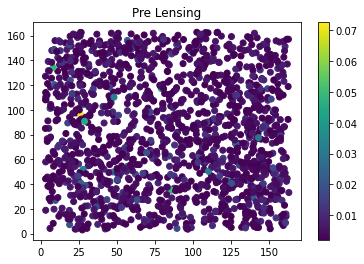

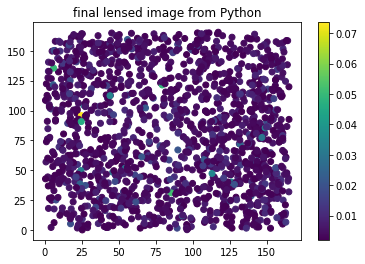

0.10111353227124104


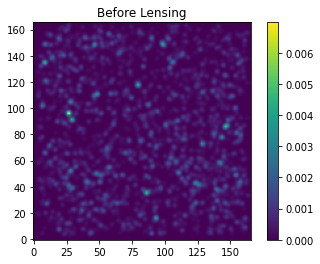

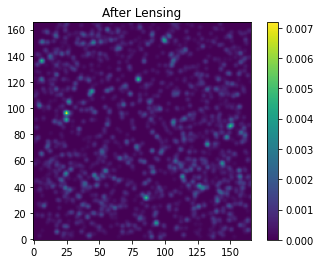

<Figure size 432x288 with 0 Axes>

In [113]:
from astropy.io import fits

lensed_flux = np.multiply(f_out, mu_out)
good_ind = np.where(x_out != -999999)[0]

lense_x = x_out[good_ind] * pixsize / 6
lense_y = y_out[good_ind] * pixsize / 6
lense_f = lensed_flux[good_ind]



SL_x = [140, 160, 160, 140, 140]
SL_y = [160, 160, 140, 140, 160]


dfxxf, dfyyf,  dffluxf = np.loadtxt('rxj1347_lense_result.txt', unpack=True)


dfxxf = dfxxf * pixsize / 6
dfyyf = dfyyf * pixsize / 6


fx = xx * pixsize / 6.
fy = yy * pixsize / 6.

# plt.title('final lensed image from IDL')
# plt.scatter(dfxxf, dfyyf, c=dffluxf)
# plt.colorbar()
# plt.show()

plt.title('Pre Lensing')
plt.scatter(fx, fy, c=dfflux)
plt.colorbar()
plt.show()


plt.title('final lensed image from Python')
plt.scatter(lense_x, lense_y, c=lense_f)
plt.colorbar()
plt.show()



psf, cf, nc, nbin = get_gaussian_psf_template(3) # assumes pixel fwhm is 3 pixels in each band


idl = image_model_eval(dfxxf, dfyyf, nc*dffluxf*100, 0.0, (170, 170), int(nc), cf)

prelense = image_model_eval(fx, fy, nc*dfflux, 0.0, (166,166), int(nc), cf)

python =  image_model_eval(lense_x, lense_y, nc*lense_f, 0.0, (166, 166), int(nc), cf)

print(np.min(nc*lense_f*2))

# plt.title('Map Produced with IDL')
# plt.imshow(idl, origin='lower', clim=(-10, 100))
# plt.colorbar()
# plt.savefig('idl_plot.png')
# plt.show()
# plt.clf()

plt.title('Before Lensing')
plt.imshow(prelense, origin='lower')
plt.colorbar()
plt.savefig('1600_before_lense.png')
plt.show()
plt.clf()

hdu = fits.PrimaryHDU(prelense)
hdul = fits.HDUList([hdu])
hdul.writeto('1600_before_lense.fits', overwrite=True)

plt.title('After Lensing')
plt.imshow(python, origin='lower')
plt.colorbar()
plt.savefig('1600_after_lense.png')
plt.show()
plt.clf()

hdu = fits.PrimaryHDU(python)
hdul = fits.HDUList([hdu])
hdul.writeto('1600_after_lense.fits', overwrite=True)

In [82]:

def get_gauss_beam(fwhm, pixscale, band, nfwhm=5.0, oversamp=1):
    retext = round(fwhm * nfwhm / pixscale)
    if retext % 2 == 0:
        retext += 1

    bmsigma = fwhm / math.sqrt(8 * math.log(2))

    beam = Gaussian2DKernel(bmsigma / pixscale, x_size=retext,
                            y_size=retext, mode='oversample',
                            factor=oversamp)
    beam *= 1.0 / beam.array.max()
    return beam

def get_gaussian_psf_template(pixel_fwhm, nbin=5):
    nc = nbin**2
    psfnew = Gaussian2DKernel(pixel_fwhm/2.355*nbin, x_size=125, y_size=125).array.astype(np.float32)
    psfnew2 = psfnew / np.max(psfnew) * nc
    cf = psf_poly_fit(psfnew, nbin=nbin)
    return psfnew2, cf, nc, nbin


import numpy as np


def psf_poly_fit(psf0, nbin):
        assert psf0.shape[0] == psf0.shape[1] # assert PSF is square
        npix = psf0.shape[0]

        # pad by one row and one column
        psf = np.zeros((npix+1, npix+1), dtype=np.float32)
        psf[0:npix, 0:npix] = psf0

        # make design matrix for each nbin x nbin region
        # print(type(npix), type(nbin))
        nc = int(npix/nbin) # dimension of original psf
        nx = nbin+1
        y, x = np.mgrid[0:nx, 0:nx] / np.float32(nbin)
        x = x.flatten()
        y = y.flatten()
        A = np.column_stack([np.full(nx*nx, 1, dtype=np.float32), x, y, x*x, x*y, y*y, x*x*x, x*x*y, x*y*y, y*y*y]).astype(np.float32)
        # output array of coefficients

        cf = np.zeros((A.shape[1], nc, nc), dtype=np.float32)

        # loop over original psf pixels and get fit coefficients
        for iy in range(nc):
            for ix in range(nc):
                # solve p = A cf for cf
                p = psf[iy*nbin:(iy+1)*nbin+1, ix*nbin:(ix+1)*nbin+1].flatten()
                AtAinv = np.linalg.inv(np.dot(A.T, A))
                ans = np.dot(AtAinv, np.dot(A.T, p))
                cf[:,iy,ix] = ans

        return cf.reshape(cf.shape[0], cf.shape[1]*cf.shape[2])

def image_model_eval(x, y, f, back, imsz, nc, cf, regsize=None, margin=0, offsetx=0, offsety=0, weights=None, ref=None, lib=None):

    # assert f.dtype == np.float32
    # not sure what to do with cf
    #assert cf.dtype == np.float32
    if ref is not None:
        assert ref.dtype == np.float32

    if weights is None:
        weights = np.full(imsz, 1., dtype=np.float32)
    # elif len(weights)==1:
    #     weights = np.full(imsz, weights, dtype=np.float32)
    if regsize is None:
        regsize = max(imsz[0], imsz[1])

    # FIXME sometimes phonions are outside image... what is best way to handle?
    goodsrc = (x > 0) * (x < imsz[0] - 1) * (y > 0) * (y < imsz[1] - 1)
    x = x.compress(goodsrc)
    y = y.compress(goodsrc)
    f = f.compress(goodsrc)

    nstar = x.size
    rad = round(nc/2) # 12 for nc = 25

    nregy = int(imsz[1]/regsize + 1) # assumes imsz % regsize = 0?
    nregx = int(imsz[0]/regsize + 1)

    ix = np.ceil(x).astype(np.int32)
    dx = ix - x
    iy = np.ceil(y).astype(np.int32)
    dy = iy - y

    dd = np.column_stack((np.full(nstar, 1., dtype=np.float32), dx, dy, dx*dx, dx*dy, dy*dy, dx*dx*dx, dx*dx*dy, dx*dy*dy, dy*dy*dy)).astype(np.float32) * f[:, None]
    if lib is None:
        image = np.full((imsz[1]+2*rad+1,imsz[0]+2*rad+1), back, dtype=np.float32)
        recon2 = np.dot(dd, cf).reshape((nstar,nc,nc))
        recon = np.zeros((nstar,nc,nc), dtype=np.float32)
        recon[:,:,:] = recon2[:,:,:]
        for i in range(nstar):
            image[iy[i]:iy[i]+rad+rad+1,ix[i]:ix[i]+rad+rad+1] += recon[i,:,:]

        image = image[rad:imsz[1]+rad,rad:imsz[0]+rad]

        if ref is not None:
            diff = ref - image
            diff2 = np.zeros((nregy, nregx), dtype=np.float64)
            for i in range(nregy):
                y0 = max(i*regsize - offsety - margin, 0)
                y1 = min((i+1)*regsize - offsety + margin, imsz[1])
                for j in range(nregx):
                    x0 = max(j*regsize - offsetx - margin, 0)
                    x1 = min((j+1)*regsize - offsetx + margin, imsz[0])
                    subdiff = diff[y0:y1,x0:x1]
                    diff2[i,j] = np.sum(subdiff*subdiff*weights[y0:y1,x0:x1])
    else:
        image = np.full((imsz[1], imsz[0]), back, dtype=np.float32)
        recon = np.zeros((nstar,nc*nc), dtype=np.float32)
        reftemp = ref
        if ref is None:
            reftemp = np.zeros((imsz[1], imsz[0]), dtype=np.float32)
        diff2 = np.zeros((nregy, nregx), dtype=np.float64)
        lib(imsz[0], imsz[1], nstar, nc, cf.shape[0], dd, cf, recon, ix, iy, image, reftemp, weights, diff2, regsize, margin, offsetx, offsety)

    # print image.shape, nc
    if ref is not None:
        return image, diff2
    else:
        return image